# Fine tune SSD with roughy data

In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import viz
from gluoncv.data import VOCDetection
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform, SSDDefaultValTransform

from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.utils.metrics.coco_detection import COCODetectionMetric
from gluoncv.utils.metrics.accuracy import Accuracy

Define a class that inherits the VOC properties

In [2]:
class VOCLike(VOCDetection):
    CLASSES = ['orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_urchin', 'oreo', 'whiptail', 'eel', 'shark', 'worm', 'misc_fish', 'mollusc', 'shrimp', 'sea_star']
    #CLASSES = ['person','dog']
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

Define the dataloader being sure to define the training transform and the validation transform.

In [3]:
def get_dataloader(net, train_dataset, val_dataset, data_shape, batch_size, num_workers, ctx):
    """Get dataloader."""
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width), ctx))
    anchors = anchors.as_in_context(mx.cpu())
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    val_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
    val_loader = gluon.data.DataLoader(
        val_dataset.transform(SSDDefaultValTransform(width, height)),
        batch_size, False, batchify_fn=val_batchify_fn, last_batch='keep', num_workers=num_workers)
    return train_loader, val_loader

Define the validation loop

In [4]:
def validate(net, val_data, ctx, eval_metric):
    """
    Test on validation dataset
    :param net: network being used
    :param val_data: validation dataset
    :param ctx: training context (flag to set gpu)
    :param eval_metric: metric to quote performance
    :return eval_metric: updated evaluation metric 
    """
    eval_metric.reset()
    # set nms threshold and topk constraint
    net.set_nms(nms_thresh=0.45, nms_topk=400)
    net.hybridize(static_alloc=True, static_shape=True)
    for batch in val_data:
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        det_bboxes = []
        det_ids = []
        det_scores = []
        gt_bboxes = []
        gt_ids = []
        gt_difficults = []
        for x, y in zip(data, label):
            # get prediction results
            ids, scores, bboxes = net(x)
            det_ids.append(ids)
            det_scores.append(scores)
            # clip to image size
            det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
            # split ground truths
            gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
            gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
            gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

        # update metric
        eval_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)
    return eval_metric.get()

Define the training function. 

In [5]:
def train(network, training_data, validation_data, eval_metric, ctx, epcs=10, val_int=2):
    """
    Fine-tune the network
    :param net: network architecture with weights being used
    :param training_data: training dataset loader
    :param validation_data: validation dataset loader
    :param ctx: training context (flag to set gpu)
    :param eval_metric: metric to quote performance on validation
    :param epcs: number of epochs to train (default=10)
    :param val_int: interval for performing validation (deafult=2)
    """
    
    #net.collect_params().reset_ctx(ctx)
    trainer = gluon.Trainer(
        net.collect_params(), 'sgd',
        {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
    
    # learning rate decay (hard corded for now)
    #lr_decay = 0.1
    
    mbox_loss = gcv.loss.SSDMultiBoxLoss()  # this is the loss function for SSD
    ce_metric = mx.metric.Loss('CrossEntropy')  
    smoothl1_metric = mx.metric.Loss('SmoothL1')
    
    # preform the epochs
    for epoch in range(0, epcs):
        ce_metric.reset()
        smoothl1_metric.reset()
        tic = time.time()
        btic = time.time()
        net.hybridize(static_alloc=True, static_shape=True)
        
        # loop over the training data in batches
        for i, batch in enumerate(train_data):
            batch_size = batch[0].shape[0]
            
            # load the images and annotations
            data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
            cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
            box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
            with autograd.record():
                cls_preds = []
                box_preds = []
                for x in data:
                    cls_pred, box_pred, _ = net(x)
                    cls_preds.append(cls_pred)
                    box_preds.append(box_pred)
                sum_loss, cls_loss, box_loss = mbox_loss(
                    cls_preds, box_preds, cls_targets, box_targets)
                autograd.backward(sum_loss)
            # since we have already normalized the loss, we don't want to normalize
            # by batch-size anymore
            trainer.step(1)
            ce_metric.update(0, [l * batch_size for l in cls_loss])
            smoothl1_metric.update(0, [l * batch_size for l in box_loss])
            name1, loss1 = ce_metric.get()
            name2, loss2 = smoothl1_metric.get()
            if i % 20 == 0:
                print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                    epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
            btic = time.time()
            
        # Validation 
        if (epoch % val_int == 0):
            map_name, mean_ap = validate(net, val_data, ctx, eval_metric)
            val_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(map_name, mean_ap)])
            #logger.info('[Epoch {}] Validation: \n{}'.format(epoch, val_msg))
            print(val_msg)
            current_map = float(mean_ap[-1])

Read in the dataset as a VOC class

In [8]:
roughy_train_dataset = VOCLike(root='VOCstarboard', splits=(('OP12', 'train'),))
roughy_val_dataset = VOCLike(root='VOCstarboard', splits=(('OP12', 'val'),))

print('Train:', len(roughy_train_dataset))
print('Val:', len(roughy_val_dataset))

Train: 100
Val: 26


Read in an image as a test.

label: [[3.189e+03 2.890e+02 3.295e+03 4.950e+02 0.000e+00 0.000e+00]
 [2.898e+03 0.000e+00 3.132e+03 3.090e+02 0.000e+00 0.000e+00]
 [1.687e+03 0.000e+00 1.950e+03 2.940e+02 0.000e+00 0.000e+00]
 [2.420e+02 2.299e+03 4.390e+02 2.471e+03 0.000e+00 0.000e+00]
 [1.794e+03 2.224e+03 2.253e+03 2.471e+03 0.000e+00 0.000e+00]
 [2.548e+03 2.401e+03 2.726e+03 2.471e+03 0.000e+00 0.000e+00]
 [2.750e+03 2.365e+03 3.011e+03 2.471e+03 0.000e+00 0.000e+00]
 [2.955e+03 2.071e+03 3.214e+03 2.471e+03 0.000e+00 0.000e+00]
 [3.037e+03 1.981e+03 3.295e+03 2.205e+03 0.000e+00 0.000e+00]
 [3.160e+03 2.060e+03 3.295e+03 2.461e+03 0.000e+00 0.000e+00]
 [0.000e+00 2.030e+03 2.710e+02 2.468e+03 0.000e+00 0.000e+00]
 [1.532e+03 2.271e+03 1.714e+03 2.414e+03 2.000e+00 0.000e+00]
 [1.680e+02 1.030e+03 6.370e+02 1.589e+03 1.000e+00 0.000e+00]
 [1.090e+02 5.580e+02 8.120e+02 9.780e+02 1.000e+00 0.000e+00]
 [8.660e+02 1.360e+03 1.576e+03 1.686e+03 1.000e+00 0.000e+00]
 [1.858e+03 1.078e+03 2.286e+03 1.804e+03 1.000e

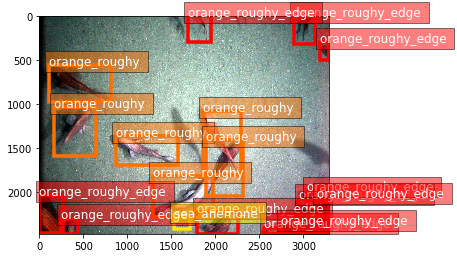

In [7]:
classes = ['orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_urchin', 'oreo', 'whiptail', 'eel', 'shark', 'worm', 'misc_fish', 'mollusc', 'shrimp', 'sea_star']
image, label = roughy_val_dataset[0]
print('label:', label)

# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

Define the validation metric. Use the VOC2007 mAP metric.

In [9]:
val_metric = VOC07MApMetric(iou_thresh=0.5, class_names=roughy_val_dataset.classes)

Look for a gpu. Use the cpu if not available.

In [10]:
contx = [mx.gpu(0)]

Load in the network weights for a low impact model.

In [11]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Put the network onto the GPU prior to loading the data

In [12]:
net.collect_params().reset_ctx(contx)

Reset the output of the network to be just orange roughy

In [13]:
net.reset_class(roughy_val_dataset.classes)

Instantiate the dataloader with the VOCLike training and val datasets.

In [14]:
train_data, val_data = get_dataloader(net, roughy_train_dataset, roughy_val_dataset, 512, 16, 0, contx[0])

Actually do the finetuning. This loop is specific to SSD. Need to update for other architectures.

In [16]:
print(roughy_val_dataset.classes)

['orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_urchin', 'oreo', 'whiptail', 'eel', 'shark', 'worm', 'misc_fish', 'mollusc', 'shrimp', 'sea_star']


In [14]:
train(net, train_data, val_data, val_metric, contx)

[Epoch 0][Batch 0], Speed: 0.317 samples/sec, CrossEntropy=14.464, SmoothL1=2.379
orange_roughy_edge=0.0
orange_roughy=0.3504089473869719
sea_anemone=0.0
sea_urchin=nan
oreo=0.0
whiptail=0.0
eel=nan
shark=nan
worm=nan
misc_fish=0.0
mollusc=0.0
shrimp=nan
sea_star=0.0
mAP=0.04380111842337149
[Epoch 1][Batch 0], Speed: 1.055 samples/sec, CrossEntropy=8.229, SmoothL1=1.684
[Epoch 2][Batch 0], Speed: 0.898 samples/sec, CrossEntropy=5.164, SmoothL1=1.817
orange_roughy_edge=0.0
orange_roughy=0.6323637095254138
sea_anemone=0.0
sea_urchin=nan
oreo=0.0
whiptail=0.0
eel=nan
shark=nan
worm=nan
misc_fish=0.0
mollusc=0.0
shrimp=nan
sea_star=0.0
mAP=0.07904546369067672
[Epoch 3][Batch 0], Speed: 0.635 samples/sec, CrossEntropy=3.945, SmoothL1=1.518
[Epoch 4][Batch 0], Speed: 0.326 samples/sec, CrossEntropy=4.233, SmoothL1=1.923
orange_roughy_edge=0.11313131313131315
orange_roughy=0.6626869981856377
sea_anemone=0.0
sea_urchin=nan
oreo=0.0
whiptail=0.0
eel=nan
shark=nan
worm=nan
misc_fish=0.0
mollusc=

Save the network weights for later use.

In [15]:
net.save_parameters('clf-outputs/090320-ssd_512_mobilenet1.0_roughy.params')

In [16]:
test_dataset = VOCLike(root='test-imgs', splits=((2018, 'test'),))

label: [[7.990e+02 1.268e+03 1.130e+03 1.555e+03 1.000e+00 0.000e+00]
 [1.135e+03 9.730e+02 1.286e+03 1.276e+03 1.000e+00 0.000e+00]
 [1.245e+03 9.730e+02 1.471e+03 1.173e+03 9.000e+00 0.000e+00]]


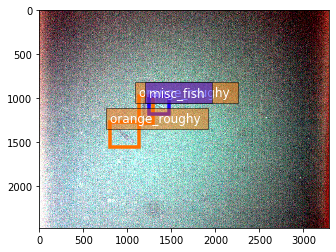

In [17]:
classes = ['orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_urchin', 'oreo', 'whiptail', 'eel', 'shark', 'worm', 'misc_fish', 'mollusc', 'shrimp', 'sea_star']
image, label = test_dataset[0]
print('label:', label)

# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

Load a test image from starboard and transform it 

In [25]:
# this is copied from above and hardcoded a lot of stuff in for a quick test [ECO 090320]

test_batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
test_loader = gluon.data.DataLoader(
    test_dataset.transform(SSDDefaultValTransform(512, 512)),
    16, False, batchify_fn=test_batchify_fn, last_batch='keep', num_workers=0)

In [26]:
map_name, mean_ap = validate(net, test_loader, contx, val_metric)
val_msg = '\n'.join(['{}={}'.format(k, v) for k, v in zip(map_name, mean_ap)])

In [27]:
print(val_msg)

orange_roughy_edge=0.3511359609686106
orange_roughy=0.7826146030224296
sea_anemone=0.0
sea_urchin=0.0
oreo=0.0
whiptail=0.0
eel=0.0
shark=0.0
worm=0.0
misc_fish=0.0
mollusc=0.0
shrimp=0.0
sea_star=0.0
mAP=0.08721158184546463


In [14]:
x, img = gcv.data.transforms.presets.ssd.load_test('test-imgs/VOC2018/JPEGImages/20190715-015011-230.jpg', 512)

In [22]:
x, img = gcv.data.transforms.presets.ssd.load_test('/home/ec2-user/SageMaker/csiro-aos-object-detection/test-imgs/VOC2018/JPEGImages/20190715-014919-257.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(img, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

MXNetError: [22:33:02] src/imperative/cached_op.cc:1041: Check failed: inputs[i]->ctx() == default_ctx (gpu(0) vs. cpu(0)) : CachedOp requires all inputs to live on the same context. But data is on cpu(0) while ssd0_mobilenet0_conv0_weight is on gpu(0)
Stack trace:
  [bt] (0) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x6e305b) [0x7f7fc935f05b]
  [bt] (1) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CachedOp::Forward(std::shared_ptr<mxnet::CachedOp> const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0x52d) [0x7f7fcc5f855d]
  [bt] (2) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOp+0x3f0) [0x7f7fcc4ce560]
  [bt] (3) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOpEx+0x40) [0x7f7fcc4cf5d0]
  [bt] (4) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f8032c9fec0]
  [bt] (5) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f8032c9f87d]
  [bt] (6) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f8032eb5d6e]
  [bt] (7) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x137a5) [0x7f8032eb67a5]
  [bt] (8) /home/ec2-user/anaconda3/envs/mxnet_p36/bin/python(_PyObject_FastCallDict+0x8b) [0x5586117b351b]

